# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introducción #

La regresión lineal destaca en la extrapolación de tendencias, pero no puede aprender interacciones. XGBoost destaca en el aprendizaje de interacciones, pero no puede extrapolar tendencias. En esta lección, aprenderemos a crear pronosticadores "híbridos" que combinen algoritmos de aprendizaje complementarios y permitan que los puntos fuertes de uno compensen los puntos débiles del otro.

# Componentes y residuos

Para poder diseñar híbridos eficaces, necesitamos comprender mejor cómo se construyen las series temporales. Hasta ahora hemos estudiado tres patrones de dependencia: tendencia, estaciones y ciclos. Muchas series temporales pueden describirse fielmente mediante un modelo aditivo de sólo estos tres componentes más algún *error* esencialmente impredecible y totalmente aleatorio:

```
serie = tendencia + estaciones + ciclos + error
```

Cada uno de los términos de este modelo se denomina **componente** de la serie temporal.

Los **residuales** de un modelo son la diferencia entre el objetivo sobre el que se ha entrenado el modelo y las predicciones que éste realiza, es decir, la diferencia entre la curva real y la curva ajustada. Si se comparan los residuos con una característica, se obtiene la parte "sobrante" del objetivo, es decir, lo que el modelo no ha aprendido sobre el objetivo a partir de esa característica.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mIeeaBD.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>La diferencia entre la serie del objetivo y las predicciones (azul) da la serie de residuales.
</center></figcaption>
</figure>

A la izquierda de la figura anterior se muestra una porción de la serie *Túnel de Tráfico* y la curva tendencia-estacional. Al restar la curva ajustada se obtienen los residuos, a la derecha. Los residuos contienen todo lo que el modelo de tendencia estacional no aprendió de *Tráfico en el túnel*.

Podríamos imaginar el aprendizaje de los componentes de una serie temporal como un proceso iterativo: primero aprendemos la tendencia y la sustraemos de la serie, después aprendemos la estacionalidad de los residuos de la tendencia y sustraemos las estaciones, después aprendemos los ciclos y sustraemos los ciclos, y finalmente sólo queda el error impredecible.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/XGJuheO.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Aprendiendo los componentes del <em>CO2 de Mauna Loa</em> paso a paso. Resta la curva ajustada (azul) de su serie para obtener la serie del siguiente paso.
</center></figcaption>
</figure>

Suma todos los componentes aprendidos y obtendremos el modelo completo. Esto es esencialmente lo que la regresión lineal haría si se entrenó en un conjunto completo de características que modelan la tendencia, las estaciones y los ciclos.

<figura style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HZEhuHF.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Añade los componentes aprendidos para obtener un modelo completo.
</center></figcaption>
</figure>

# Previsión híbrida con residuales

En lecciones anteriores, hemos utilizado un único algoritmo (regresión lineal) para aprender todos los componentes a la vez. Pero también es posible utilizar un algoritmo para algunos de los componentes y otro algoritmo para el resto. De este modo, siempre podemos elegir el mejor algoritmo para cada componente. Para ello, utilizamos un algoritmo para ajustar la serie original y luego el segundo algoritmo para ajustar la serie residual.

En detalle, el proceso es el siguiente
```
# 1. Entrenar y predecir con el primer modelo
model_1.fit(X_entrenamiento_1, y_entrenamiento)
y_pred_1 = modelo_1.predecir(X_entrenamiento)

# 2. 2. Entrenar y predecir con el segundo modelo sobre los residuos
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = modelo_2.predecir(X_entrenamiento_2)

# 3. Añadir para obtener predicciones globales
y_pred = y_pred_1 + y_pred_2
```

Normalmente querremos utilizar diferentes conjuntos de características (`X_entrenamiento_1` y `X_entrenamiento_2` más arriba) dependiendo de lo que queramos que aprenda cada modelo. Si utilizamos el primer modelo para aprender la tendencia, generalmente no necesitaremos una función de tendencia para el segundo modelo, por ejemplo.

Aunque es posible utilizar más de dos modelos, en la práctica no parece ser especialmente útil. De hecho, la estrategia más común para construir híbridos es la que acabamos de describir: un algoritmo de aprendizaje simple (normalmente lineal) seguido de un aprendiz complejo no lineal como GBDT o una red neuronal profunda, el modelo simple diseñado normalmente como "ayudante" para el potente algoritmo que le sigue.

### Diseño de híbridos

Hay muchas formas de combinar modelos de aprendizaje automático, además de la que hemos descrito en esta lección. Combinar modelos con éxito, sin embargo, requiere que profundicemos un poco más en cómo funcionan estos algoritmos.

En general, hay dos formas en que un algoritmo de regresión puede hacer predicciones: transformando las *características* o transformando el *objetivo*. Los algoritmos de transformación de características aprenden alguna función matemática que toma las características como entrada y luego las combina y transforma para producir una salida que coincida con los valores objetivo del conjunto de entrenamiento. La regresión lineal y las redes neuronales son de este tipo.

Los algoritmos de transformación de objetivos utilizan las características para agrupar los valores objetivo en el conjunto de entrenamiento y realizar predicciones promediando los valores de un grupo; un conjunto de características sólo indica qué grupo promediar. Los árboles de decisión y los vecinos más próximos son de este tipo.

Lo importante es lo siguiente: los transformadores de características generalmente pueden **extrapolar** valores objetivo más allá del conjunto de entrenamiento dadas las características apropiadas como entradas, pero las predicciones de los transformadores de objetivos siempre estarán limitadas dentro del rango del conjunto de entrenamiento. Si el tiempo ficticio continúa contando pasos de tiempo, la regresión lineal continúa dibujando la línea de tendencia. Dado el mismo tiempo ficticio, un árbol de decisión predecirá la tendencia indicada por el último paso de los datos de entrenamiento en el futuro para siempre. *Los árboles de decisión no pueden extrapolar tendencias. Los bosques aleatorios y los árboles de decisión de gradiente aumentado (como XGBoost) son conjuntos de árboles de decisión, por lo que tampoco pueden extrapolar tendencias.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZZtfuFJ.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Un árbol de decisión no podrá extrapolar una tendencia más allá del conjunto de entrenamiento.
</center></figcaption>
</figure>

Esta diferencia es lo que motiva el diseño híbrido de esta lección: utilizar la regresión lineal para extrapolar la tendencia, transformar el *objetivo* para eliminar la tendencia y aplicar XGBoost a los residuos sin tendencia. Para hibridar una red neuronal (un transformador de características), podría incluir las predicciones de otro modelo como una característica, que la red neuronal incluiría como parte de sus propias predicciones. El método de ajuste a los residuos es en realidad el mismo método que utiliza el algoritmo de aumento de gradiente, por lo que los llamaremos **híbridos aumentados**; el método de utilizar predicciones como características se conoce como "apilamiento", por lo que los llamaremos **híbridos apilados**.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Híbridos ganadores de las competiciones de Kaggle</strong>
    <p>Para inspirarte, aquí tienes algunas soluciones con las mejores puntuaciones de competiciones pasadas:</p> <ul>
<ul>
    <li><a href="https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125">STL boosted with exponential smoothing</a> - Walmart Recruiting - Store Sales Forecasting</li>
    <li><a href="https://www.kaggle.com/c/rossmann-store-sales/discussion/17896">ARIMA y suavizado exponencial potenciados con GBDT</a> - Rossmann Store Sales</li>
    <li><a href="https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395">Un conjunto de híbridos apilados y potenciados</a> - Predicción de series temporales de tráfico web</li>
    <li><a href="https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf">Alisamiento exponencial apilado con red neuronal LSTM</a> - M4 (no Kaggle)</li>
</ul>
</blockquote>

# Ejemplo - Ventas al por menor en EE.UU.

El conjunto de datos [*US Retail Sales*](https://www.census.gov/retail/index.html) contiene datos de ventas mensuales para varias industrias minoristas desde 1992 hasta 2019, según lo recopilado por la Oficina del Censo de Estados Unidos. Nuestro objetivo será pronosticar las ventas en los años 2016-2019 dadas las ventas en los años anteriores. Además de crear un híbrido de regresión lineal + XGBoost, también veremos cómo configurar un conjunto de datos de series temporales para su uso con XGBoost.

In [4]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

data_dir = Path("data")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

c:\Users\jamr1\miniconda3\envs\gym2\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\jamr1\AppData\Local\Temp\ipykernel_340\3201619667.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

Primero vamos a utilizar un modelo de regresión lineal para conocer la tendencia de cada serie. Como demostración, utilizaremos una tendencia cuadrática (orden 2). (El código aquí es básicamente el mismo que en NoteBooks anteriores.) Aunque el ajuste no es perfecto, será suficiente para nuestras necesidades.

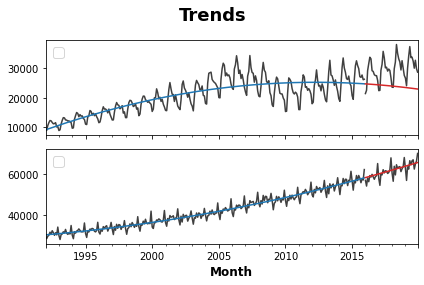

In [5]:

y = retail.copy()

# Crear características de tendencia
dp = DeterministicProcess(
    index=y.index,  
    constant=True,  
    order=2,        
    drop=True,     
)
X = dp.in_sample()  

# Test sobre los años 2016-2019. Será más fácil para nosotros más tarde si
# dividimos el índice de fechas en lugar del dataframe directamente.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Mientras que el algoritmo de regresión lineal es capaz de realizar una regresión de múltiples salidas, el algoritmo XGBoost no lo es. Para predecir múltiples series a la vez con XGBoost, en su lugar convertiremos estas series de formato *ancho*, con una serie temporal por columna, a formato *largo*, con series indexadas por categorías a lo largo de las filas.

In [6]:
# El método `stack` convierte las etiquetas de columna en etiquetas de fila, pasando del formato ancho al largo
X = retail.stack()  
display(X.head())
y = X.pop('Sales')

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Para que XGBoost pueda aprender a distinguir nuestras dos series temporales, convertiremos las etiquetas de fila de "Industrias" en una característica categórica con una codificación de etiqueta. También crearemos una función para la estacionalidad anual extrayendo los números de los meses del índice temporal.

In [7]:
# Convierte las etiquetas de las filas en columnas de características categóricas con una codificación de etiquetas.
X = X.reset_index('Industries')
# Label encoding
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding 
X["Month"] = X.index.month 

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Ahora convertiremos las predicciones de tendencia realizadas anteriormente a formato largo y luego las restaremos de la serie original. Así obtendremos series sin tendencia (residuales) que XGBoost puede aprender.

In [10]:
# Pivotear ancho a largo (stack) y convertir DataFrame a Series (squeeze)
y_fit = y_fit.stack().squeeze()    
y_pred = y_pred.stack().squeeze()  

# Crear residuos (la colección de series sin tendencia) a partir del conjunto de entrenamiento
y_resid = y_train - y_fit

# Train XGBoost 
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Añadir los residuos previstos a las tendencias previstas
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

El ajuste parece bastante bueno, aunque podemos ver cómo la tendencia aprendida por XGBoost es sólo tan buena como la tendencia aprendida por la regresión lineal -- en particular, XGBoost no fue capaz de compensar la tendencia mal ajustada en la serie `'MaterialesDeConstrucción'`.

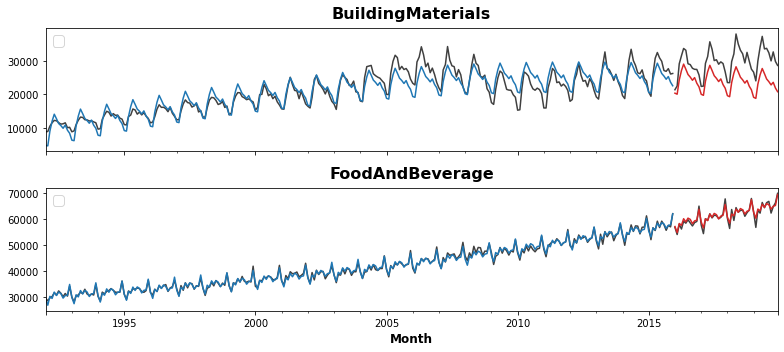

In [11]:

axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])